In [1]:
# IMPORTO LIBRERIE

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from Libreria_tesi import *

Definizioni delle condizioni sperimentali che si vuole riprodurre in accordo a paper "Projective measurements can probe nonclassical
work extraction and time correlations"

In [72]:
# ————————————————————————————————
# 1) Definizioni di base secondo Eq. (16)
# ————————————————————————————————
hbar = 1.0
D       = 2.87      # zero‐field splitting [GHz]
gamma_e = 28.0      # gyromagnetic ratio [GHz/T]
B       = 0.01      # campo esterno [T]

# Base del qutrit |+1>, |0>, |-1>
e_plus  = basis(3, 0)
e_zero  = basis(3, 1)
e_minus = basis(3, 2)

# Hamiltoniana NV
Sz = Qobj(np.diag([+1, 0, -1]))
H_NV = D * Sz**2 + gamma_e * B * Sz

# ————————————————————————————————
# 2) Hamiltoniana nel S.d.R del laboratorio, Eq. (17)
# ——————————————————————————————————————————————————————————
# frequenze di Bohr
omega_p = D + gamma_e * B    # |0> <--> |+1>
omega_m = D - gamma_e * B    # |0> <--> |-1>

# operatori di transizione
P_p0 = e_plus  * e_zero.dag()  + e_zero * e_plus.dag()  # |+1> <--> |0>
P_m0 = e_minus * e_zero.dag()  + e_zero * e_minus.dag() # |-1> <--> |0>

# Rabi frequencies
Omega1 = 2.219 * 2*np.pi  * 10**(-3)         # MHz 
Omega2 = Omega1                               

def H_drive_lab(t, args):
    phi1, phi2 = args.get('phi1',0), args.get('phi2',0)  # da dizionario le fasi oppure setto a zero
    H1 = Omega1 * np.cos(omega_p * t + phi1) * P_p0
    H2 = Omega2 * np.cos(omega_m * t + phi2) * P_m0
    return H1 + H2

# lista per qutip
H_lab = [
    H_NV,   # parte stazionaria
    [P_p0, lambda t, args: hbar*Omega1 * np.cos(omega_p * t + args.get('phi1',0)*t)],
    [P_m0, lambda t, args: hbar*Omega2 * np.cos(omega_m * t + args.get('phi2',0)*t)]
]

# ————————————————————————————————
# 3) Hamiltoniana nel rotating frame, Eq. (18)
# ——————————————————————————————————————————————
# Matrici di Gell-Mann
lambda1 = Qobj([[0,1,0],[1,0,0],[0,0,0]])
lambda2 = Qobj([[0,-1j,0],[1j,0,0],[0,0,0]])
lambda6 = Qobj([[0,0,0],[0,0,1],[0,1,0]])
lambda7 = Qobj([[0,0,0],[0,0,-1j],[0,1j,0]])

Sx1 = lambda1/np.sqrt(2)
Sy1 = lambda2/np.sqrt(2)
Sx2 = lambda6/np.sqrt(2)
Sy2 = lambda7/np.sqrt(2)

def H_rot(t, args = {'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2}):
    # fasi lineari
    phi1, phi2 = args.get('phi1',0), args.get('phi2',0)
    return ( Omega1*(Sx1 * np.cos(phi1*t) + Sy1 * np.sin(phi1*t))
           + Omega2*(Sx2 * np.cos(phi2*t) - Sy2 * np.sin(phi2*t)) )

H_mw_rot = [
    [Sx1, lambda t,args:  Omega1 * np.cos(args.get('phi1',0)*t)],
    [Sy1, lambda t,args:  Omega1 * np.sin(args.get('phi1',0)*t)],
    [Sx2, lambda t,args:  Omega2 * np.cos(args.get('phi2',0)*t)],
    [Sy2, lambda t,args: -Omega2 * np.sin(args.get('phi2',0)*t)],
]

# ———————————————————
# 4) Stato iniziale 
# ———————————————————
p_plus, p_zero, p_minus = 0.7654, 0.0009, 0.2338
a_plus, a_zero, a_minus = 0.0073, 0.2787, 0.0002


H_val = H_rot(0, args = {}) # Hamiltoniana iniziale nel frame ruotato

en, aut = H_val.eigenstates()

vet_m, vet_0, vet_p = aut

xi = (
    np.sqrt(p_plus ) * np.exp(2j*np.pi*a_plus ) * vet_p  +
    np.sqrt(p_zero ) * np.exp(2j*np.pi*a_zero ) * vet_0  +
    np.sqrt(p_minus) * np.exp(2j*np.pi*a_minus) * vet_m
).unit()

# Stato iniziale (matrice densità)
rho_xi = xi * xi.dag()


In [73]:
# Operatori di dephasing (tempo dipendenti)

def collapse_ops(t, args):
    # ricava H(t) nel frame ruotante
    Ht = H_rot(t, args)
    # diagonalizza
    _, evecs = Ht.eigenstates()
    
    # costruiisci i tre L
    L_p0 = evecs[2]*evecs[2].dag() - evecs[1]*evecs[1].dag()
    L_0m = evecs[1]*evecs[1].dag() - evecs[0]*evecs[0].dag()
    L_pm = evecs[2]*evecs[2].dag() - evecs[0]*evecs[0].dag()
    gamma = args.get('gamma_phi', 0.001)
    return [
        # np.sqrt(gamma)*L_p0,
        # np.sqrt(gamma)*L_0m,
        np.sqrt(gamma)*L_pm,
    ]

c_ops_ist = collapse_ops(0, args={'gamma_phi': 0.0025})

Confronto ad un dato istante temporale fra le MHQ e le probabilità restituite dallo schema TPM

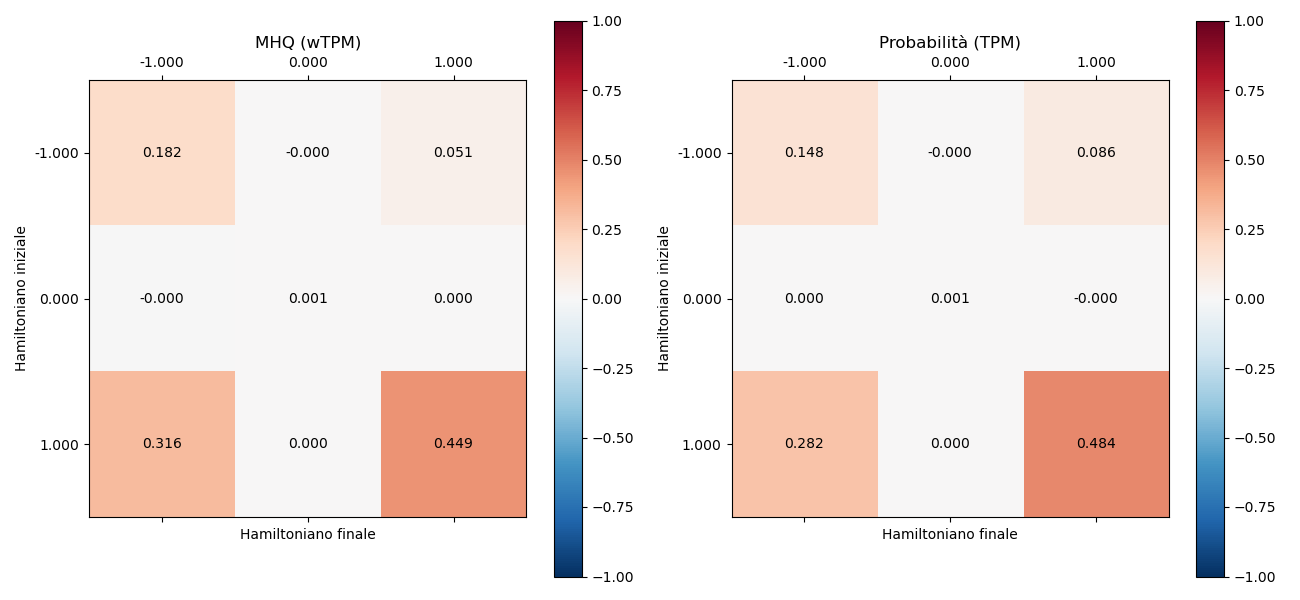

Verifica marginalizzazione:
 ∑_i p[i, -1] = 0.4294,     p_END[-1] = 0.4987,    ∑_i q[i,-1] = 0.4987
 ∑_i p[i,  0] = 0.0009,     p_END[ 0] = 0.0009,    ∑_i q[i, 0] = 0.0009
 ∑_i p[i,  1] = 0.5697,     p_END[ 1] = 0.5004,    ∑_i q[i, 1] = 0.5004

Somma totale TPM: 1.0000
Somma totale MHQ: 1.0000


In [74]:
%matplotlib widget

# intervallo temporale
t_max = 300
n_steps = 500
t_list = np.linspace(0, t_max, n_steps)



# Dephasing puro
L5 = vet_0 * vet_0.dag() - vet_m * vet_m.dag()
L6 =  vet_p * vet_p.dag() - vet_0 * vet_0.dag()
# L7 = vet_p * vet_p.dag() - vet_m * vet_m.dag()


gamma_5 = 0.005
gamma_6 = 0.005
# gamma_7 = 0.0003

c_ops = [
    np.sqrt(gamma_5)*L5,
    np.sqrt(gamma_6)*L6,
    # np.sqrt(gamma_7)*L7,
]
    

# Operatori iniziale e finale
H_iniziale = H_rot(0, args={'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2})                        
H_finale = H_rot(t_list[-1], args={'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2})                  

# Calcolo MHQ
Q, TPM, probabilita_finali = MHQ_3level_vecchia(rho_xi, H_mw_rot, c_ops_ist, H_iniziale, H_finale, t_list[:-1], args={'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2})
    
# Estrazione autovalori per i labels
autovalori_1, _ = H_iniziale.eigenstates()
autovalori_2, _ = H_finale.eigenstates()
    
autovalori_1 = [np.real(val)/Omega1 for val in autovalori_1]
autovalori_2 = [np.real(val)/Omega1 for val in autovalori_2]
    
# Visualizzazione
plot_MHQ_3level(Q, TPM, autovalori_1, autovalori_2)
    
# Verifica marginalizzazione
print("Verifica marginalizzazione:")
for j in range(3):
    print(f" ∑_i p[i, {j-1:2.0f}] = {TPM[:,j].sum():.4f},     p_END[{j-1:2.0f}] = {probabilita_finali[j]:.4f},    ∑_i q[i,{j-1:2.0f}] = {Q[:,j].sum():.4f}")
    
print(f"\nSomma totale TPM: {TPM.sum():.4f}")
print(f"Somma totale MHQ: {Q.sum():.4f}")

In [75]:
plt.close("all")



# intervallo temporale
t_max = 1600
n_steps = 500
t_list = np.linspace(0, t_max, n_steps)

# Inizializzo risultati
Q_evolution = np.zeros((n_steps, 3, 3)) # salvo le diverse matrici Q per ogni t
TPM_evolution = np.zeros((n_steps, 3, 3)) # salvo le TPM per ogni t
prob = np.zeros((n_steps, 3))

args = {'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2}

# Calcolo MHQ per ogni t_final
for idx, t_final in enumerate(t_list):
    t_sublist = t_list[:idx+1]  
    Q, TPM, iniziali = MHQ_3level(rho_xi, H_mw_rot, c_ops_ist, H_iniziale, H_rot(t_sublist[-1]), t_sublist, args = args, iniziali= False)  
    Q_evolution[idx] = Q
    TPM_evolution[idx] = TPM
    prob[idx] = iniziali

C:\Users\samue\AppData\Local\Temp\ipykernel_14276\980762893.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  Q_evolution[idx] = Q


KeyboardInterrupt: 

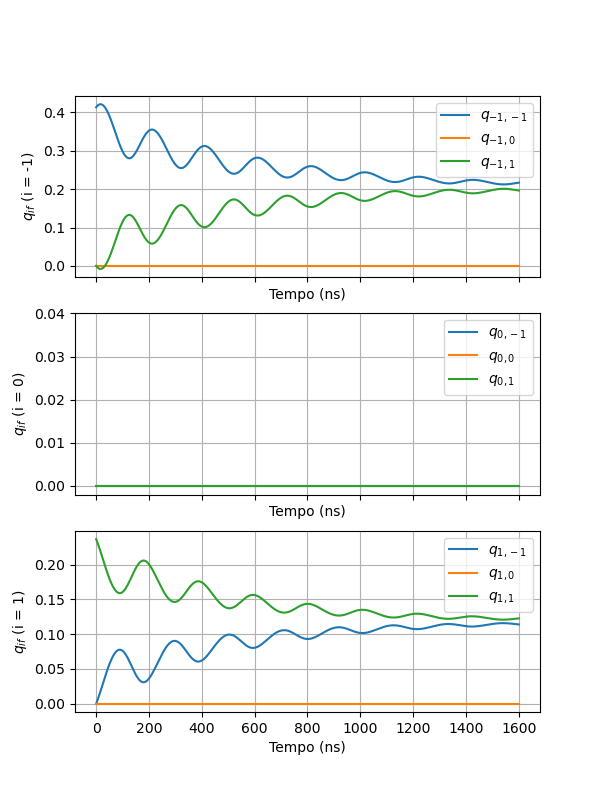

In [67]:
fig, ax = plt.subplots(3,1, figsize =(6, 8), sharex=True)
# Plot di Q[i,j](t)
for i in range(3):
    for j in range(3):
        ax[i].plot(t_list, Q_evolution[:, i, j], label=f'$q_{{{i-1:2.0f},{j-1:2.0f}}}$')
    ax[i].set_xlabel('Tempo (ns)')
    ax[i].set_ylabel(f'$q_{{if}}$ (i = {i-1})')
    #ax[i].set_title(f'Evoluzione quasiprobabilità')
    ax[i].legend(loc='upper right')
    ax[i].grid()

ax[1].set_ylim([-0.002, 0.04])
plt.show()
plt.tight_layout()

Lavoro estraibile

In [68]:
lavoro = []
lavoro_TPM = [] 
temp = 0
H_iniziale = H_rot(0, args={'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2})
autovalori_1, _ = H_iniziale.eigenstates()
lim_sup = []
lim_inf = []


for t in range(len(t_list)):
    temp = 0
    temp_TPM = 0
    for i in range(3):
        for j in range(3):
            h = H_rot(t_list[t], args={'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2})
            energia, _ = h.eigenstates()
            temp += Q_evolution[t, i, j] * (autovalori_1[i] - energia[j])/ Omega1
            temp_TPM += TPM_evolution[t, i, j] * (autovalori_1[i] - energia[j]) / Omega1
    lavoro.append(temp)
    lavoro_TPM.append(temp_TPM)


def round_to_zero(x, threshold=1e-14):
    return 0 if abs(x) < threshold else x

for t in range(len(t_list)):
    temp = 0
    temp_2 = 0
    for i in range(3):
        for j in range(3):
            h = H_rot(t_list[t], args={'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2})
            energia, _ = h.eigenstates()
            if (autovalori_1[i] - energia[j]) > 0:
                temp += np.sqrt(round_to_zero(TPM_evolution[t, i, j]*prob[t, j])) * (autovalori_1[i] - energia[j]) / Omega1
            else:
                temp_2 += np.sqrt(round_to_zero(TPM_evolution[t, i, j]*prob[t, j])) * (autovalori_1[i] - energia[j]) / Omega1
    lim_sup.append(temp)
    lim_inf.append(temp_2)
    


C:\Users\samue\AppData\Local\Temp\ipykernel_14276\4273203982.py:36: RuntimeWarning: invalid value encountered in sqrt
  temp_2 += np.sqrt(round_to_zero(TPM_evolution[t, i, j]*prob[t, j])) * (autovalori_1[i] - energia[j]) / Omega1
C:\Users\samue\AppData\Local\Temp\ipykernel_14276\4273203982.py:34: RuntimeWarning: invalid value encountered in sqrt
  temp += np.sqrt(round_to_zero(TPM_evolution[t, i, j]*prob[t, j])) * (autovalori_1[i] - energia[j]) / Omega1


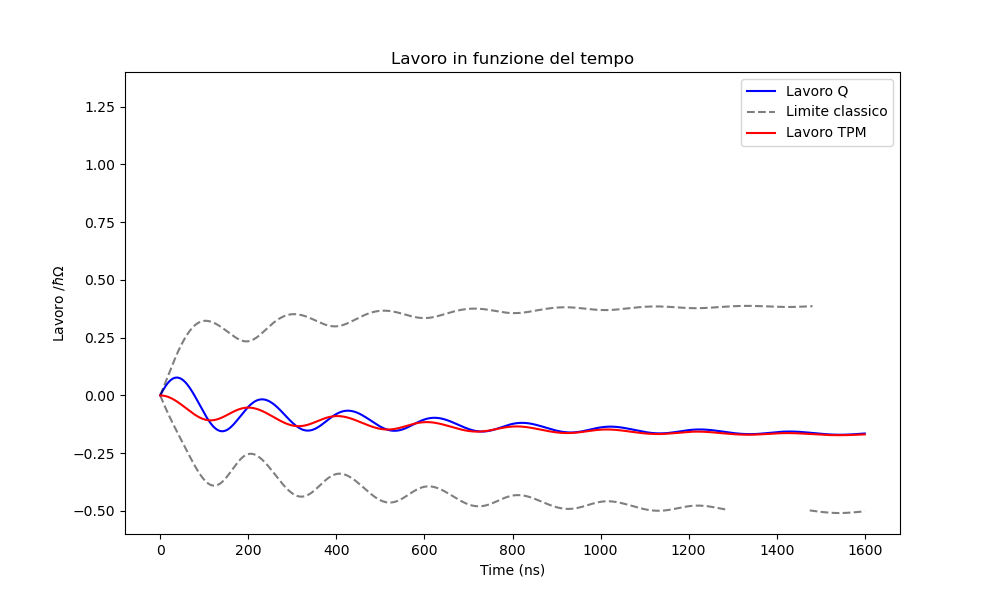

In [69]:
plt.close("all")
plt.figure(figsize=(10, 6))
plt.plot(t_list, lavoro, label='Lavoro Q', color = "b")
plt.plot(t_list, lim_sup, label= "Limite classico", linestyle='--', color = "k", alpha=0.5)
plt.plot(t_list, lim_inf, linestyle='--', color = "k", alpha=0.5)
plt.plot(t_list, lavoro_TPM, label='Lavoro TPM', color = "r")
plt.legend()
plt.ylim(-0.6, 1.4)
plt.xlabel('Time (ns)')
plt.ylabel(r'Lavoro /$\hbar\Omega$')
plt.title('Lavoro in funzione del tempo')
plt.show()
plt.grid()



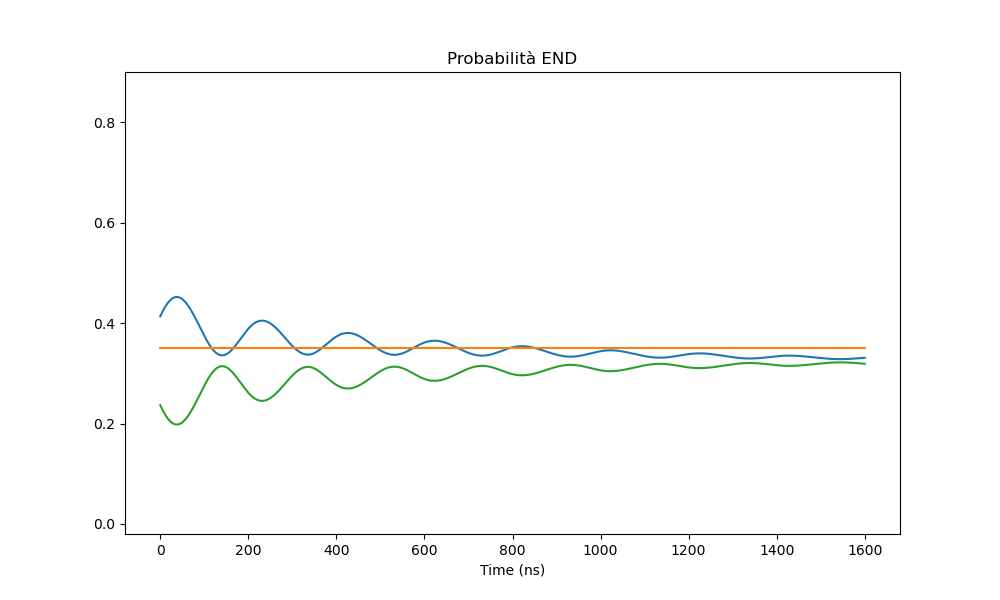

In [70]:
plt.close("all")
plt.figure(figsize=(10, 6))
plt.plot(t_list, prob[:,0], label ="$p_{{-1}}^{{END}}$")
plt.plot(t_list, prob[:,1], label ="$p_{{0}}^{{END}}$")
plt.plot(t_list, prob[:,2], label ="$p_{{+1}}^{{END}}$")
plt.title('Probabilità END')
plt.xlabel('Time (ns)')
plt.ylim(-0.02, 0.9)
plt.show()
plt.grid()
plt.legend()

c:\Users\samue\miniconda3\envs\BASE\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\samue\miniconda3\envs\BASE\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


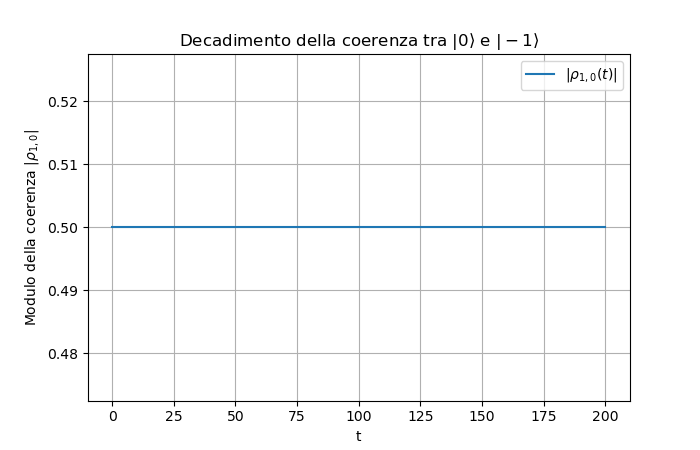

In [ ]:
plt.close("all")

# Hamiltoniano nullo (studiamo solo il dephasing)
H = 1 *qeye(3)

# Stato iniziale: sovrapposizione fra |0> e |-1>
psi0 = (e_zero + e_plus).unit()
rho0 = ket2dm(psi0)

# Operatori di decoerenza
L5 = e_zero * e_zero.dag() - e_minus * e_minus.dag() 
L6 = e_plus * e_plus.dag() - e_zero * e_zero.dag()  
L7 = e_plus * e_plus.dag() - e_minus * e_minus.dag()

# Tassi di dephasing
gamma_phi_5 = 0.001
gamma_phi_6 = 0.1
gamma_phi_7 = 0.001

c_ops = [
    np.sqrt(gamma_phi_6) * L6,
    # np.sqrt(gamma_phi_5) * L5,
    # np.sqrt(gamma_phi_7) * L7,
]

# Evoluzione temporale
tlist = np.linspace(0, 200, 200)
result = mesolve(H, rho0, tlist, c_ops=c_ops,)

# Estrazione della coerenza rho_{0,-1}(t)
coerenza_10 = [np.abs(rho[0,1]) for rho in result.states]

p_1 = [(e_plus * e_plus.dag()*rho).tr() for rho in result.states] # Per studio popolazioni

plt.figure(figsize=(7,4.5))
plt.plot(tlist, p_1, label=r'$|\rho_{1,0}(t)|$')
plt.xlabel('t')
plt.ylabel("Modulo della coerenza " r"$|\rho_{1,0}|$")
plt.title('Decadimento della coerenza tra $|0\\rangle$ e $|+1\\rangle$')
plt.grid()
plt.legend()
plt.show()

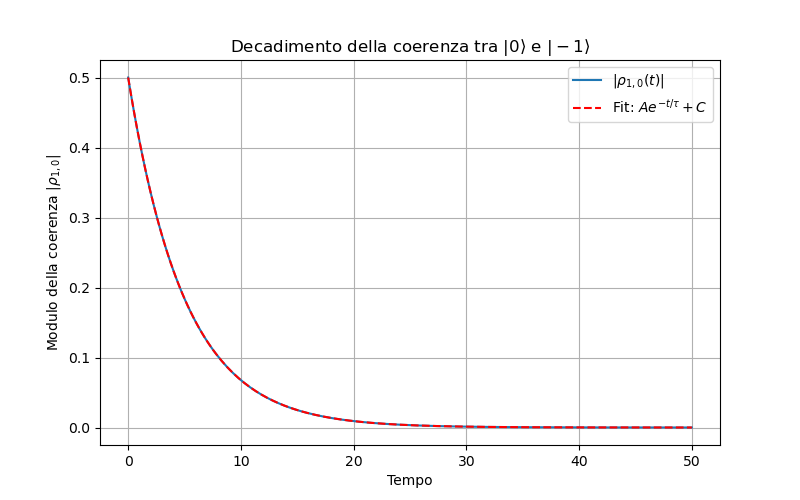

Parametri del fit: A = 0.5000, tau = 5.0000, C = 0.0000


In [99]:
from scipy.optimize import curve_fit

def exp_decay(t, A, tau, C):
    return A * np.exp(-t/tau) + C

# Fit della coerenza
pof, _ = curve_fit(exp_decay, tlist, coerenza_10, p0=[1, 10, 0])
plt.figure(figsize=(8,5))
plt.plot(tlist, coerenza_10, label=r'$|\rho_{1,0}(t)|$')
plt.plot(tlist, exp_decay(tlist, *pof), 'r--', label='Fit: $A e^{-t/\\tau} + C$')
plt.xlabel('Tempo')
plt.ylabel("Modulo della coerenza " r"$|\rho_{1,0}|$")
plt.title('Decadimento della coerenza tra $|0\\rangle$ e $|-1\\rangle$')
plt.grid()
plt.legend()
plt.show()

print(f"Parametri del fit: A = {pof[0]:.4f}, tau = {pof[1]:.4f}, C = {pof[2]:.4f}")

In [107]:
print(prob[1:3])

[[0.23381259 0.00089991 0.7652875 ]
 [0.23534507 0.00089991 0.76375502]]


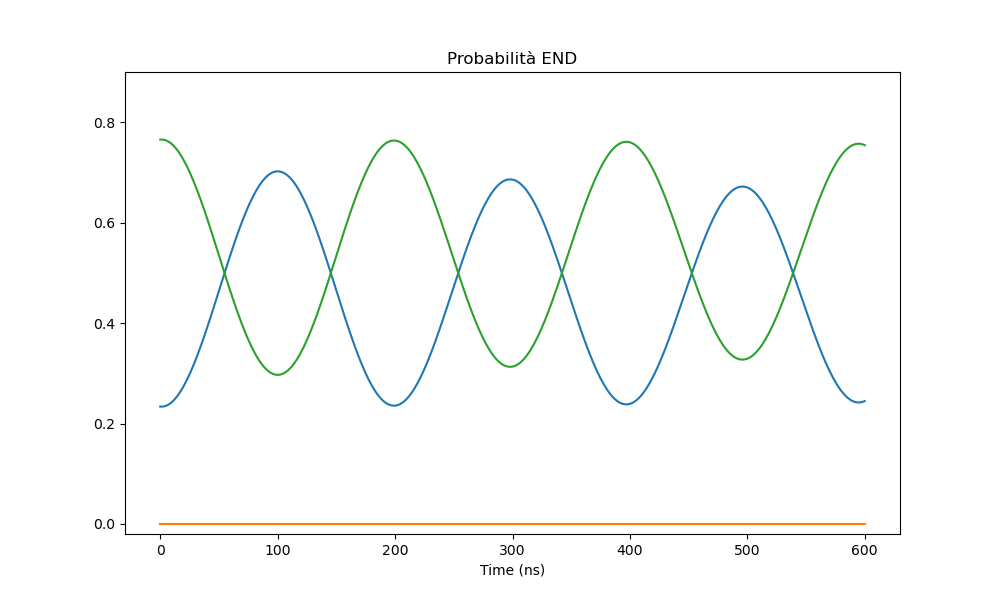

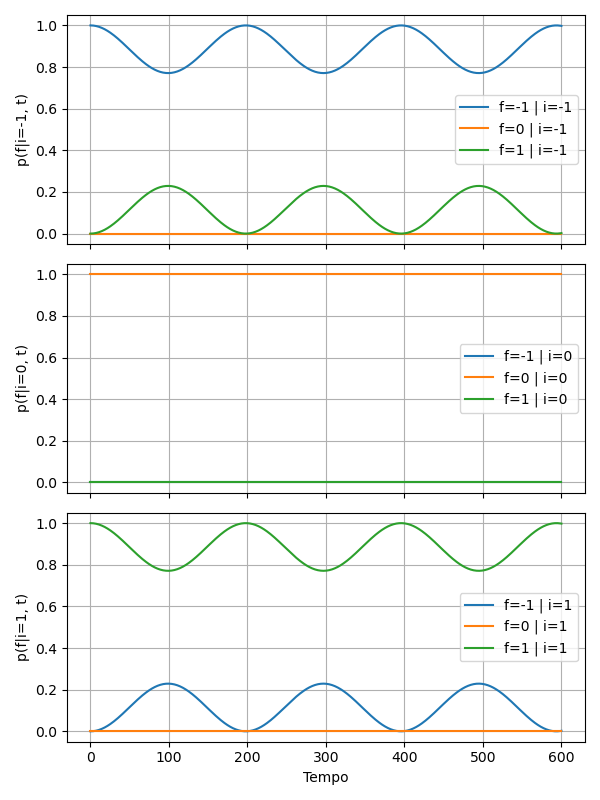

In [29]:
plt.close("all")
# Calcolo
t_max = 600
n_steps = 500
t_list = np.linspace(0, t_max, n_steps)

TPM_time_inst = prob_condizionate( 
    rho_xi,
    H_mw_rot,
    c_ops=[],
    O1=H_iniziale,
    H_final_func=lambda t: H_rot(t),
    t_list=t_list,
    args={'phi1':1.09*Omega1, 'phi2':1.09*Omega2}
)


# Eseguire il plot
plot_prob_cond(TPM_time_inst, t_list)